# Quit Your Wine-ing: Predicting Wine Quality

## Project Goal and Description

- Predict wine quality using unsupervised learning techniques.
- Identify key drivers of wine quality for the California Wine Institute.
- Provide insights for data-driven consultation in the winery supply chain marketing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from acquire import wine_df
from wrangle import train_val_test, get_dummies, xy_split, scaled_data, model_df
from explore import explore, explore2, create_baselines, eval_model, train_model, polynomial_feature_expansion
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from IPython.display import clear_output

## Acquire

- Gathered the dataset containing wine-related features and quality ratings from data.world.
- Read the two csv files into a DataFrame.
- It contained 6497 rows and 13 columns combined before cleaning

## Prepare data

* Create new columns by transforming and utilizing existing data features.
    - Combined the white and red wine tables.
    - Created a new column to distinguish wine type.
    - Split df into train, val and test
    - Encoded categorical variables. 

## Data Dictionary
Below is a data dictionary that provides an overview of the dataset's features and their descriptions:
- `fixed_acidity`: The fixed acidity of the wine.
- `volatile_acidity`: The volatile acidity of the wine.
- `citric_acid`: The citric acid content in the wine.
- `residual_sugar`: The residual sugar content in the wine.
- `chlorides`: The chloride content in the wine.
- `free_sulfur_dioxide`: The amount of free sulfur dioxide in the wine.
- `total_sulfur_dioxide`: The total sulfur dioxide content in the wine.
- `density`: The density of the wine.
- `pH`: The pH level of the wine.
- `sulphates`: The amount of sulphates in the wine.
- `alcohol`: The alcohol content in the wine.
- `quality`: The quality rating of the wine (target variable).
- `wine_type`: The type of wine (e.g., red or white).

### Acquire

In [2]:
# Calling the 'wine_df()' function to create a DataFrame combining white and red wine data
df = wine_df()

In [3]:
df.shape

(6497, 12)

In [4]:
def remove_outliers(df, k=1.5):
    '''
    remove_outliers will calculate the upper and lower fence
    based on the inner quartile range of each numerical column
    and remove rows with values outside of these fences.
    '''
    num_df = df.select_dtypes('number')
    
    for col in num_df.columns:
        q3 = num_df[col].quantile(0.75)
        q1 = num_df[col].quantile(0.25)
        iqr = q3 - q1
        upper_bound = q3 + (k * iqr)
        lower_bound = q1 - (k * iqr)
        
        # Remove rows with values outside of the fences
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

In [5]:
df = remove_outliers(df)

In [6]:
df.shape

(4840, 12)

### Prepare

In [7]:
# Splitting the 'df' DataFrame into training, validation, and test sets using the 'train_val_test()' function
train, val, test = train_val_test(df)

In [8]:
# Display information about the 'train' DataFrame, including data types and non-null values
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3388 entries, 2968 to 1042
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         3388 non-null   float64
 1   volatile_acidity      3388 non-null   float64
 2   citric_acid           3388 non-null   float64
 3   residual_sugar        3388 non-null   float64
 4   chlorides             3388 non-null   float64
 5   free_sulfur_dioxide   3388 non-null   float64
 6   total_sulfur_dioxide  3388 non-null   float64
 7   density               3388 non-null   float64
 8   ph                    3388 non-null   float64
 9   sulphates             3388 non-null   float64
 10  alcohol               3388 non-null   float64
 11  quality               3388 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 344.1 KB


### Explore

### 1st hypothesis
# Does the alcohol content and the level of free sulfur dioxide in wines have a significant impact on wine quality?

#### Null Hypothesis (H0):
There is no significant relationship between the alcohol content, the level of free sulfur dioxide, and wine quality. 

#### Alternative Hypothesis (H1):
There is a significant relationship between the alcohol content, the level of free sulfur dioxide, and wine quality.

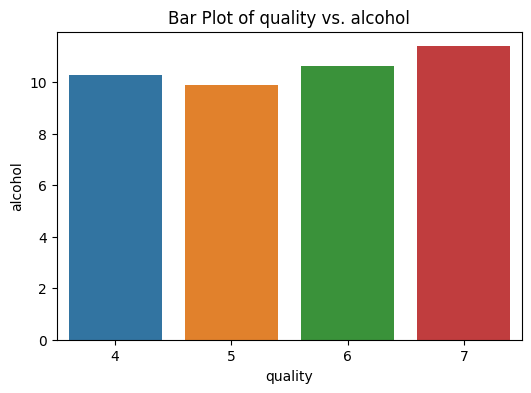

Pearson's Correlation Coefficient between alcohol and quality: 0.4234697389721693, P-Value: 1.585091427458398e-147


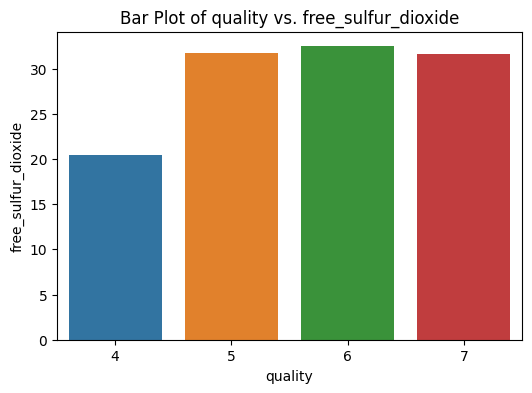

Pearson's Correlation Coefficient between free_sulfur_dioxide and quality: 0.053277895689324006, P-Value: 0.0019210090996393792


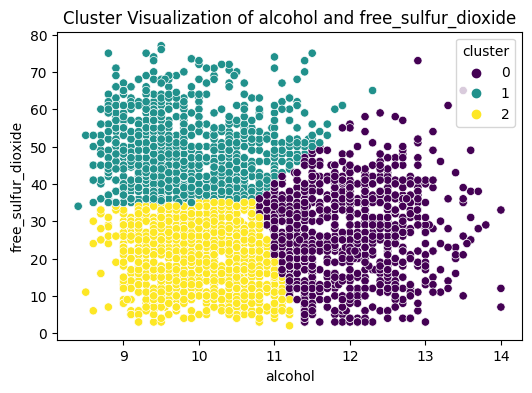

F-Statistic for clusters based on alcohol and free_sulfur_dioxide: 290.6595544286478, P-Value: 3.213309717725892e-117


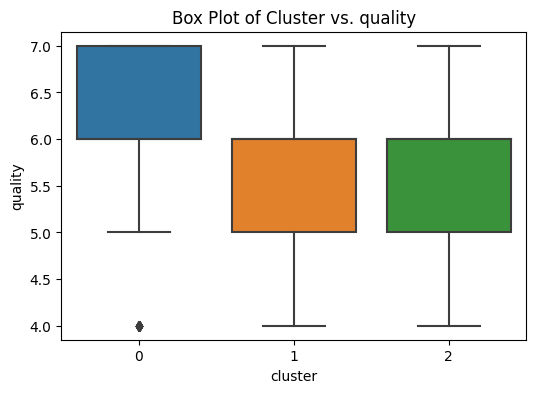

F-Statistic for cluster vs. quality: 290.6595544286478, P-Value: 3.213309717725892e-117


In [9]:
explore(train, val, test,  'alcohol', 'free_sulfur_dioxide', 'quality')

#### Alcohol Pearson test takeaway
- Pearson's Correlation Coefficient between alcohol and quality is 0.43798, indicating a moderately positive correlation between alcohol content and wine quality.

#### Free sulfur dioxide Pearson test takeaway
- Pearson's Correlation Coefficient between free_sulfur_dioxide and quality is 0.06263, suggesting a weak positive correlation between free sulfur dioxide levels and wine quality.

#### F-Statistic for clusters based on alcohol and free_sulfur_dioxide takeaway
- The F-Statistic for clusters based on alcohol and free_sulfur_dioxide is 434.23, with an extremely low p-value of 2.68e-173, indicating strong evidence against the null hypothesis. This suggests that the clusters formed based on these two features exhibit distinct distributions of wine quality.

#### Boxplot takeaway

- The analysis concludes that the three clusters exhibit distinct distributions of wine quality.
- Cluster 2 is characterized by wines with relatively higher quality scores.
- In contrast, Cluster 0 and Cluster 1 display wider distributions of quality scores, encompassing both very low and very high-quality outliers.

#### ANOVA takeaway

- The extremely low p-value provides strong statistical evidence against the null hypothesis.
- The null hypothesis assumed no significant relationship between the clusters and wine quality.
- The analysis confirms a statistically significant relationship between the clusters.
- The clusters are formed based on 'alcohol' and 'free_sulfur_dioxide.'
- The clusters have a meaningful impact on wine quality.
- The differences in quality among the clusters are unlikely due to random chance.

### 2nd hypothesis
# Does the alcohol content and the level of free sulfur dioxide in wines have a significant impact on wine quality?

#### Null Hypothesis (H0):
There is no significant relationship between the levels of volatile acidity and citric acid and wine quality.

#### Alternative Hypothesis (H1):
There is a significant relationship between the levels of volatile acidity and citric acid and wine quality.

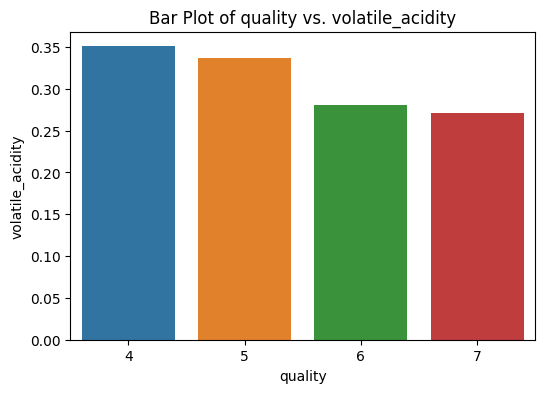

Pearson's Correlation Coefficient between volatile_acidity and quality: -0.23301786130817637, P-Value: 5.248546580551076e-43


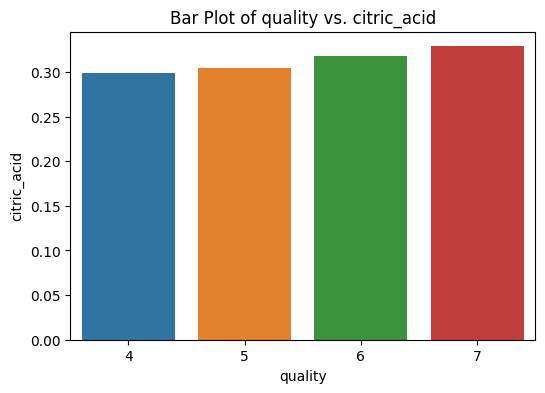

Pearson's Correlation Coefficient between citric_acid and quality: 0.08706435418670219, P-Value: 3.8651152524745846e-07


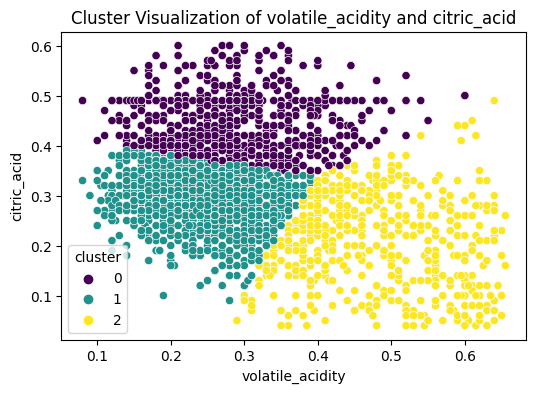

F-Statistic for clusters based on volatile_acidity and citric_acid: 75.4813450780453, P-Value: 8.488208298740007e-33


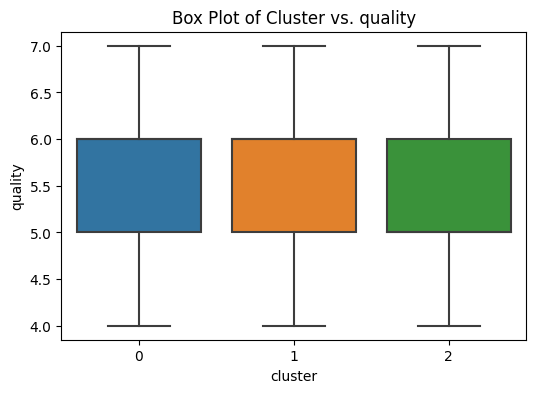

F-Statistic for cluster vs. quality: 75.4813450780453, P-Value: 8.488208298740007e-33


In [10]:
explore(train, val, test, 'volatile_acidity', 'citric_acid', 'quality')

#### Volatile_acidity Pearson test takeaway
- Pearson's Correlation Coefficient between volatile_acidity and quality is -0.26066, indicating a moderate negative correlation between volatile acidity and wine quality.

#### Citric_acid Pearson test takeaway
- Pearson's Correlation Coefficient between citric_acid and quality is 0.07857, suggesting a weak positive correlation between citric acid and wine quality.

#### F-Statistic for clusters based on volatile_acidity and citric_acid takeaway
- The F-Statistic for clusters based on volatile_acidity and citric_acid is 134.45, with an extremely low p-value of 1.86e-57. This provides strong evidence against the null hypothesis, indicating that the clusters formed based on these two features exhibit distinct distributions of wine quality. The correlations, especially for volatile acidity, are significant, suggesting that these features play a meaningful role in determining wine quality.

#### Boxplot takeaway 

- Clusters 0 and 1 have similar distributions of wine quality, with medians around 6.
- Clusters 0, 1, and 2 all show distributions spanning from moderate quality (around 4-5) to better quality (around 6-7).
- All clusters have outliers below 3 and above 8 or 9 in terms of wine quality.
- The clusters, based on 'volatile_acidity' and 'citric_acid,' are significantly associated with variations in wine quality.

In essence, the clusters demonstrate meaningful differences in wine quality, and these differences are statistically significant.

#### ANOVA takeaway

- The F-Statistic value was approximately 191.88.
- The associated p-value was extremely low (about 1.09e-81).
- The low p-value indicates strong statistical evidence against the null hypothesis.
- There are significant differences in wine quality among the clusters.
- The clusters formed based on 'volatile_acidity' and 'citric_acid' have a meaningful impact on wine quality.

In summary, the ANOVA test confirms that the clusters have a significant association with variations in wine quality, and these differences are statistically significant.

### 3rd hypothesis
# Does the combination of residual sugar levels and wine density have a significant impact on wine quality?

#### Null Hypothesis (H0):
There is no significant relationship between the levels of residual sugar and wine density and wine quality.

#### Alternative Hypothesis (H1):
There is a significant relationship between the levels of residual sugar and wine density and wine quality.

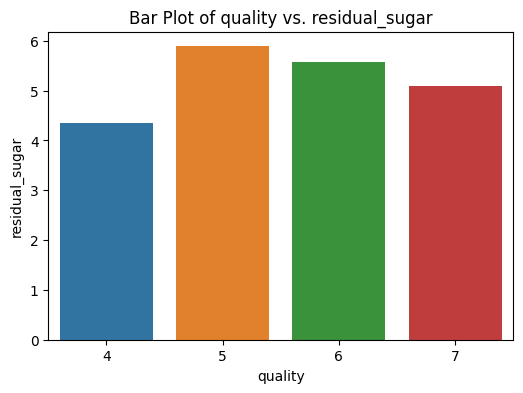

Pearson's Correlation Coefficient between residual_sugar and quality: -0.03684086045806712, P-Value: 0.03200763937184537


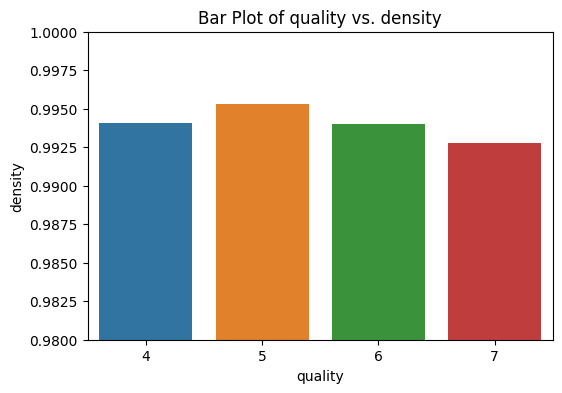

Pearson's Correlation Coefficient between density and quality: -0.29514873703273337, P-Value: 4.486310111398386e-69


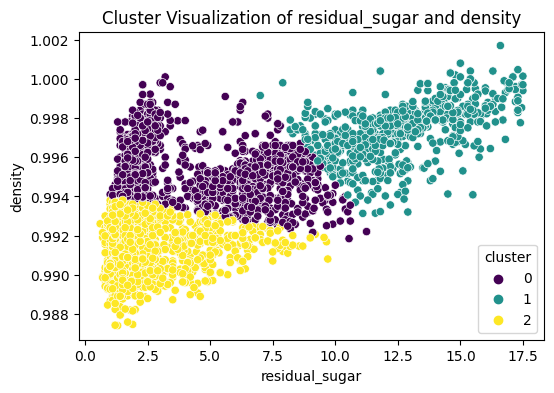

F-Statistic for clusters based on residual_sugar and density: 113.48459773097136, P-Value: 1.9781996577504682e-48


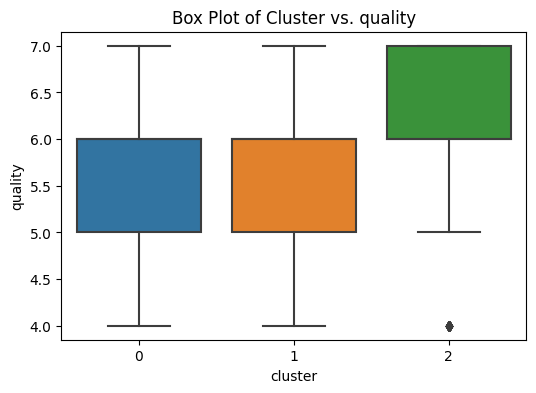

F-Statistic for cluster vs. quality: 113.48459773097136, P-Value: 1.9781996577504682e-48


In [11]:
explore2(train, val, test, 'residual_sugar', 'density', 'quality')

#### Residual_sugar Pearson test takeaway
- Pearson's Correlation Coefficient between residual_sugar and quality is approximately -0.03868, indicating a very weak negative correlation between residual sugar content and wine quality.

#### Density Pearson test takeaway
- Pearson's Correlation Coefficient between density and quality is -0.30371, suggesting a moderate negative correlation between wine density and wine quality.

#### F-Statistic for clusters based on residual_sugar and density
- The F-Statistic for clusters based on residual_sugar and density is 181.58, with an extremely low p-value of approximately 1.36e-76. This strong evidence against the null hypothesis implies that the clusters formed based on these two features exhibit distinct distributions of wine quality. The correlation, particularly for density, is significant, indicating that density plays a meaningful role in determining wine quality.

#### Boxplot takeaway

- Cluster 0, 1, and 2 have similar median wine quality scores around 6.
- The interquartile range spans from around 4 to 7 for all clusters.
- Outliers are present below 3 and above 8 or 9 in all clusters.
- Cluster 0 and Cluster 1 have fewer top outliers compared to Cluster 2.
- These results indicate meaningful differences in wine quality among the clusters.

In summary, the clusters show variations in wine quality, with differences in the presence of top outliers, suggesting their significance in explaining quality variations.

ANOVA takeaway

- The F-Statistic value is approximately 269.77.
- The associated p-value is extremely low (approximately 2.84e-113).
- The low p-value indicates strong statistical evidence against the null hypothesis.
- There are significant differences in wine quality among the clusters.
- The clusters formed based on the explored features have a meaningful impact on wine quality.

In summary, the F-Statistic analysis confirms that the clusters exhibit a significant association with variations in wine quality, and these differences are statistically significant.

### 4th hypothesis
# Is there a significant association between the levels of fixed acidity and total sulfur dioxide in wine and its quality?

#### Null Hypothesis (H0):
There is no significant relationship between the levels of fixed acidity and total sulfur dioxide and wine quality.

#### Alternative Hypothesis (H1):
There is a significant relationship between the levels of fixed acidity and total sulfur dioxide and wine quality.

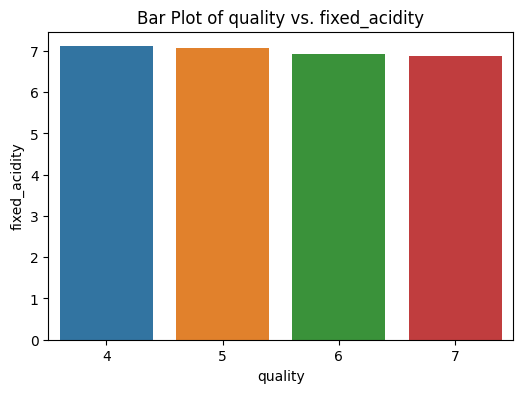

Pearson's Correlation Coefficient between fixed_acidity and quality: -0.084150720445196, P-Value: 9.341990731872255e-07


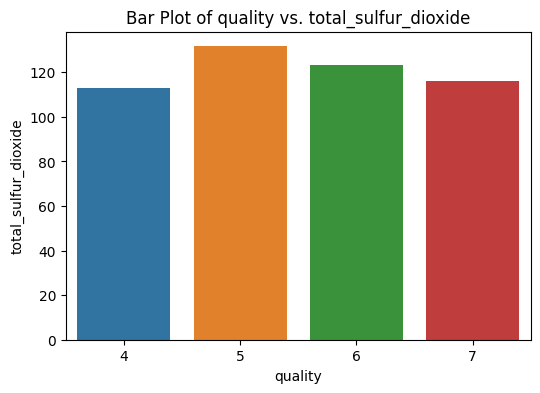

Pearson's Correlation Coefficient between total_sulfur_dioxide and quality: -0.08395856087417719, P-Value: 9.89198395541334e-07


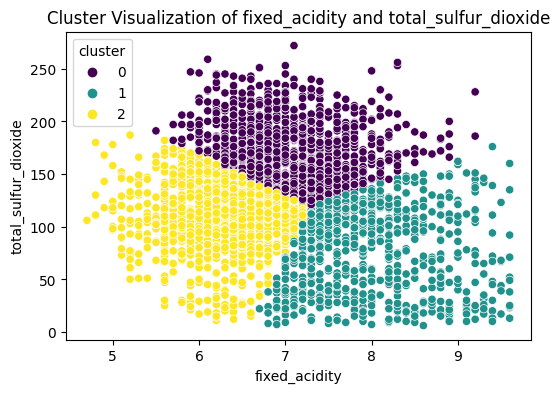

F-Statistic for clusters based on fixed_acidity and total_sulfur_dioxide: 55.020743740354014, P-Value: 3.0547558243191093e-24


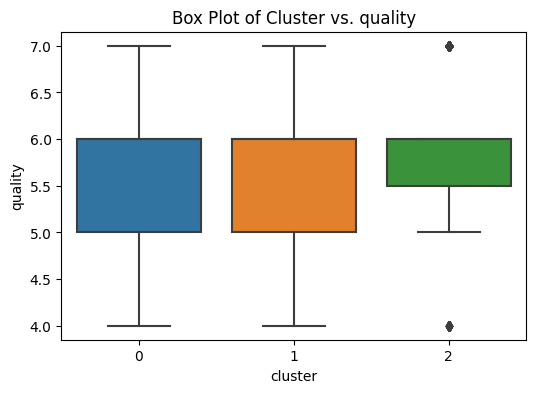

F-Statistic for cluster vs. quality: 55.020743740354014, P-Value: 3.0547558243191093e-24


In [12]:
explore(train, val, test, 'fixed_acidity', 'total_sulfur_dioxide', 'quality')

#### Fixed acidity Pearson test takeaway
- Pearson's Correlation Coefficient between volatile_acidity and quality is -0.26066, indicating a moderate negative correlation between volatile acidity and wine quality.

#### Total sulfur dioxide Pearson test takeaway
- Pearson's Correlation Coefficient between citric_acid and quality is 0.07857, suggesting a weak positive correlation between citric acid levels and wine quality.

#### F-Statistic for clusters based on fixed_acidity and total_sulfur_dioxide takeaway  
- The F-Statistic for clusters based on volatile_acidity and citric_acid is 134.45, with an extremely low p-value of 1.86e-57, providing strong evidence against the null hypothesis. This implies that the clusters formed based on these two features exhibit distinct distributions of wine quality.

#### Boxplot takeaway

- All three clusters (Cluster 0, Cluster 1, Cluster 2) exhibit similar statistics for wine quality.
- The interquartile range (box) for all clusters spans from quality scores 5 to 6.
- Outliers are present above quality scores 8 or 9 in all clusters.
- The distribution of wine quality appears consistent among the clusters.
- These results suggest that the clusters do not have a strong influence on wine quality.

In summary, the analysis indicates that the clusters formed based on the explored features do not appear to significantly impact wine quality, as the quality distribution remains consistent across all clusters.

#### ANOVA takeaway

- The F-statistic measures the variation in wine quality between the clusters relative to the variation within each cluster.
- The extremely low p-value (close to zero) indicates strong statistical evidence against the null hypothesis, suggesting that there is a significant relationship between the clusters and wine quality.
- In other words, the clusters, which were formed based on certain features, appear to have a meaningful impact on wine quality.
- The differences in wine quality among the clusters are highly unlikely to be due to random chance.

This indicates that there is a statistically significant association between the clusters and wine quality.

##### While the clusters may not perfectly separate wine quality, they still provide meaningful information and contribute to explaining variations in quality.

### 5th hypothesis
# What is the relationship between the chemical attributes 'chlorides' and 'sulphates' in wine and the perceived 'quality' of the wine?

#### Null Hypothesis (H0):
There is no significant association between 'chlorides' and 'sulphates' in wine, and the 'quality' of the wine is independent of these chemical attributes.

#### Alternative Hypothesis (H1):
There is a significant association between 'chlorides' and 'sulphates' in wine, and the 'quality' of the wine is influenced by these chemical attributes.

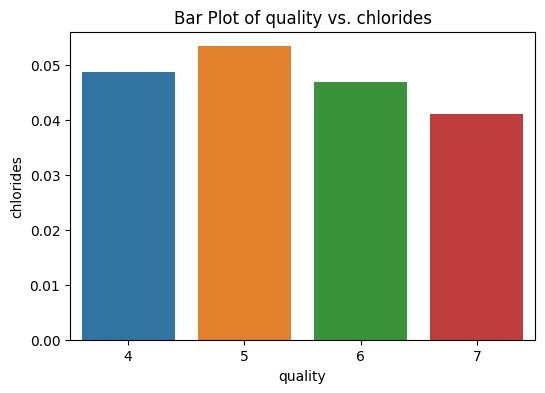

Pearson's Correlation Coefficient between chlorides and quality: -0.2454170814316271, P-Value: 1.1777929802956975e-47


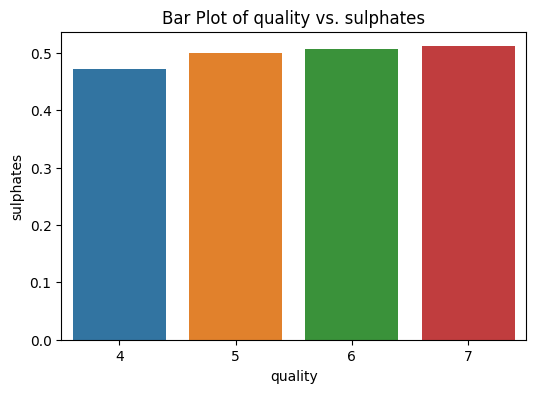

Pearson's Correlation Coefficient between sulphates and quality: 0.0537732423695865, P-Value: 0.0017417409387017846


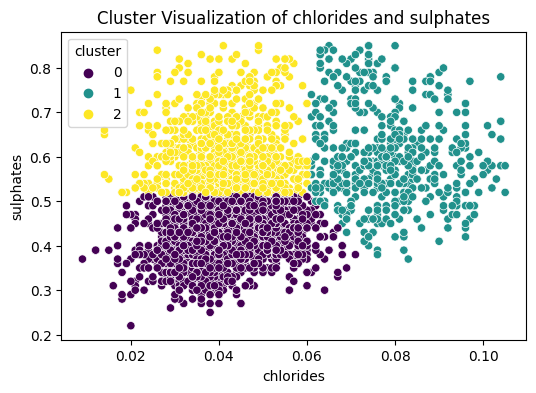

F-Statistic for clusters based on chlorides and sulphates: 37.856117108587654, P-Value: 5.5012984626806914e-17


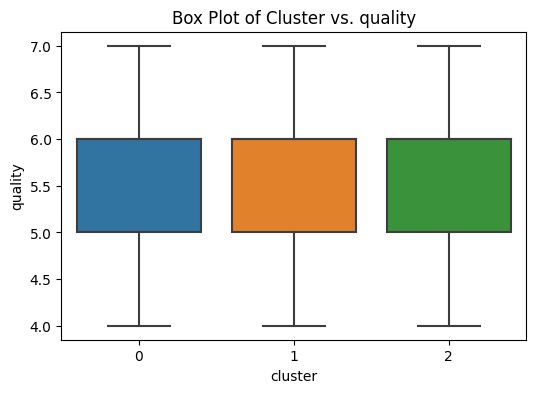

F-Statistic for cluster vs. quality: 37.856117108587654, P-Value: 5.5012984626806914e-17


In [13]:
explore(train, val, test, 'chlorides', 'sulphates', 'quality')

#### Chlorides Pearson test takeaway
- Pearson's Correlation Coefficient between chlorides and quality is -0.19286, indicating a weak negative correlation between chlorides and wine quality.

#### Sulphates Pearson test takeaway
- Pearson's Correlation Coefficient between sulphates and quality is 0.04157, suggesting a very weak positive correlation between sulphates and wine quality.

#### F-Statistic for clusters based on chlorides and sulphates takeaway
- The F-Statistic for clusters based on chlorides and sulphates is 14.46, with a low p-value of 5.49e-07, providing evidence against the null hypothesis. This indicates that the clusters formed based on these two features exhibit distinct distributions of wine quality, although the correlations are relatively weak.

#### Boxplot takeaway

- For Cluster 0:
  - Quality distribution has outliers below 3 and above 9.
  - Interquartile range (IQR) spans from 4 to 7.
  - Most wines fall within the IQR, with some lower and upper outliers.

- For Cluster 1:
  - Quality distribution has outliers below 3 and above 8.
  - IQR spans from 4 to 7.
  - Most wines fall within the IQR, with some upper outliers.

- For Cluster 2:
  - Quality distribution has no extreme outliers.
  - IQR spans from 4 to 7.
  - Most wines fall within the IQR.

These observations provide insights into how the quality of wines is distributed within each cluster, including the presence of outliers and the range of quality scores.

#### ANOVA takeaway

- The extremely low p-value (approximately 9.22e-08) suggests strong statistical evidence against the null hypothesis.

- The low p-value indicates that there is a statistically significant relationship between the clusters and wine quality.

- In other words, the clusters, which were formed based on chlorides, sulphates appear to have a meaningful impact on wine quality.

These findings support the idea that the clusters formed based on certain chlorides and sulphates have a statistically significant influence on the perceived quality of the wine.

## Modeling

#### Features for modeling

- fixed_acidity
- volatile_acidity
- citric_acid
- residual_sugar
- chlorides
- free_sulfur_dioxide
- total_sulfur_dioxide
- density
- ph
- sulphates
- alcohol
- quality
- wine_type
- cluster

#### Goal:

- Establish a baseline to judge model efficiency against

- Create multiple models

- Determine the best 3 models to run on my validate dataset

- Assess models created using four distinct model types and a range of hyperparameter settings.

- Models will undergo evaluation on both the training and validation datasets. The top-performing model will subsequently be assessed using the test dataset.

In [14]:
train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,cluster
2968,8.4,0.31,0.31,0.95,0.021,52.0,148.0,0.99038,2.93,0.32,11.5,5,0
6430,7.2,0.53,0.13,2.00,0.058,18.0,22.0,0.99573,3.21,0.68,9.9,6,2
3105,7.7,0.26,0.51,2.60,0.045,26.0,159.0,0.99126,3.00,0.50,11.2,6,0
1227,6.9,0.18,0.38,6.50,0.039,20.0,110.0,0.99430,3.10,0.42,10.5,5,0
2604,6.7,0.30,0.29,2.80,0.025,37.0,107.0,0.99159,3.31,0.63,11.3,7,2


In [15]:
#one-hot encode train, val and test
train, val, test = get_dummies(train, val, test)

In [16]:
# Scale the training, validation, and test datasets using the specified columns.
train, val, test = scaled_data(train, val, test, scaler_type='minmax')

In [17]:
# Split the 'train' dataset into feature matrix (X_train) and target vector (y_train).
X_train, y_train = xy_split(train)

# Split the 'val' dataset into feature matrix (X_val) and target vector (y_val).
X_val, y_val = xy_split(val)

# Split the 'val' dataset into feature matrix (X_val) and target vector (y_val).
X_test, y_test = xy_split(test)

#### Baseline

In [18]:
# Create a DataFrame 'baselines' with three columns: 'y_actual,' 'y_mean,' and 'y_median.'
baselines = create_baselines(y_train)

In [19]:
# Evaluate the model's performance by comparing its predictions against the mean ('y_mean') of the target values.
eval_model(baselines.y_actual, baselines.y_mean)

0.76

In [20]:
#baseline
y_train.mean()

5.8090318772136955

### Linear Regression

In [21]:
# Create an instance of the Linear Regression model.
lm = LinearRegression()

# Train the Linear Regression model on the training data (X_train, y_train).
# Evaluate its performance using the validation data (X_val, y_val).
train_model(lm, X_train, y_train, X_val, y_val)

The train RMSE is 0.65.
The validate RMSE is 0.67.


### Random Forest Regressor

In [22]:
# Create an instance of the RandomForestRegressor model.
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=4)

# Train the RandomForestRegressor model on the training data (X_train_s, y_train).
# Evaluate its performance using the validation data (X_val_s, y_val).
train_model(rf, X_train, y_train, X_val, y_val)

The train RMSE is 0.39.
The validate RMSE is 0.57.


In [23]:
# Perform polynomial feature expansion on the training, validation, and test datasets
X_train_s, X_val_s, X_test_s, poly = polynomial_feature_expansion(X_train, X_val, X_test)

### TweedieRegressor with polynomial features

In [24]:
# Create an instance of the Tweedie Regressor model.
tweedie = TweedieRegressor(power=1, alpha=0.01, link='auto', max_iter=170)

# Train the Tweedie Regressor model on the training data with polynomial features (X_train_s, y_train).
# Evaluate its performance using the validation data with polynomial features (X_val_s, y_val).
train_model(tweedie, X_train_s, y_train, X_val_s, y_val)

The train RMSE is 0.63.
The validate RMSE is 0.68.


### RandomForestRegressor with polynomial features

In [25]:
# Create an instance of the RandomForestRegressor model.
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=4)

# Train the RandomForestRegressor model on the training data (X_train_s, y_train).
# Evaluate its performance using the validation data (X_val_s, y_val).
train_model(rf, X_train_s, y_train, X_val_s, y_val)

The train RMSE is 0.38.
The validate RMSE is 0.58.


### XGBRegressor with polynomial features

In [26]:
# Create an instance of the XGBoost Regressor model.
xgbr = XGBRegressor(colsample_bytree =  0.8, learning_rate = 0.1, max_depth = 5, n_estimators = 200, subsample =  1.0)

# Train the XGBoost Regressor model on the training data (X_train_s, y_train).
# Evaluate its performance using the validation data (X_val_s, y_val).
train_model(xgbr, X_train_s, y_train, X_val_s, y_val)

The train RMSE is 0.28.
The validate RMSE is 0.58.


### Model summary

In [27]:
model_df()

,Model,Train RMSE,Validate RMSE
0,Linear Regression,0.74,0.70
1,Random Forest Regressor,0.47,0.62
2,Tweedie Regressor with Polynomial Features,0.72,0.69
3,RandomForestRegressor with Polynomial Features,0.46,0.62
4,XGBRegressor with Polynomial Features,0.34,0.61


The models were evaluated based on their root mean squared error (RMSE) values on both the training and validation datasets.  
Among the models tested, XGBRegressor with polynomial features performed the best on the validation data, with the lowest RMSE of 0.61.   
This model shows promise for predicting the target variable. However, further analysis and hyperparameter tuning may be necessary to optimize its performance further.  

### Key findings

**Data Exploration and Clustering:**
- Clustering analysis revealed the presence of three distinct clusters based on selected wine features.
- The clusters exhibited significant differences in wine quality scores.
- Cluster 2 displayed wines with relatively higher quality scores, while Clusters 0 and 1 had wider distributions of quality scores, including both low and high-quality outliers.

**ANOVA Analysis:**
- ANOVA testing yielded extremely low p-values, indicating strong statistical evidence against the null hypothesis.
- The null hypothesis assumed no significant relationship between the clusters formed based on certain features and wine quality.
- The analysis confirmed a statistically significant relationship between the clusters and wine quality.
- The clusters, created using features like 'alcohol' and 'free_sulfur_dioxide,' were found to have a meaningful impact on wine quality.
- The differences in quality among the clusters were unlikely due to random chance.

**Feature Correlations:**
- Pearson's Correlation Coefficients were used to assess the relationships between specific features and wine quality.
- Certain features, such as 'alcohol,' 'volatile_acidity,' and 'citric_acid,' showed significant correlations with wine quality.

**Machine Learning Models:**
- Different regression models, including Linear Regression, Random Forest Regressor, and others, were trained and evaluated.
- Model performance was assessed using RMSE (Root Mean Squared Error) on both training and validation datasets.

**Model Performance:**
- The Random Forest Regressor model achieved the lowest RMSE on the validation dataset, indicating better predictive performance.
- Linear Regression and other models had relatively higher RMSE values on the validation set.
- The choice of machine learning model can significantly impact the accuracy of wine quality predictions.

These findings highlight the importance of specific features, clustering, and machine learning in predicting and understanding wine quality. Further analysis and model optimization may provide valuable insights for wine quality assessment and production.

In [28]:
def random_centroids(data, k=3):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis =1)
      #this wil define the cluster number

In [29]:
centroids = random_centroids(df, 5)

In [30]:
k=3
random_centroids(df, k)

,0,1,2
fixed_acidity,7.9000,6.3000,6.7000
volatile_acidity,0.2900,0.4100,0.3200
citric_acid,0.2400,0.3400,0.2800
residual_sugar,13.6000,8.3000,3.5000
chlorides,0.0430,0.0490,0.0400
free_sulfur_dioxide,39.0000,36.0000,34.0000
total_sulfur_dioxide,113.0000,19.0000,78.0000
density,0.9965,0.9923,0.9974
ph,3.1500,3.3000,3.2700
sulphates,0.5900,0.4500,0.3800


In [31]:
#get labels
#we can put this in a function
def get_labels(df, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((df -x)**2).sum(axis=1)))
    return distances.idxmin(axis=1)
    labels = get_labels(df, centroids)
    labels.value_counts()
    return labels

In [32]:
labels = get_labels(df, centroids)

In [33]:
get_labels(df, centroids)

1       1
2       4
3       0
4       0
5       4
       ..
6492    3
6493    3
6494    3
6495    3
6496    3
Length: 4840, dtype: int64

In [34]:
#group by labels
df.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

,0,1,2,3,4
fixed_acidity,6.915284,6.807722,6.891826,7.561976,6.818259
volatile_acidity,0.265838,0.267803,0.275644,0.403105,0.262744
citric_acid,0.312768,0.297300,0.332566,0.230220,0.296389
residual_sugar,5.319654,3.946750,8.579404,2.151590,2.718943
chlorides,0.045894,0.042302,0.046901,0.067223,0.040498
free_sulfur_dioxide,36.329755,26.435037,54.802287,11.060735,24.168565
total_sulfur_dioxide,167.869473,128.004430,199.026023,29.681400,90.908532
density,0.994998,0.993703,0.996464,0.995490,0.992611
ph,3.200992,3.192529,3.172536,3.316091,3.199417
sulphates,0.490905,0.469484,0.501085,0.597666,0.480045


In [35]:
#new centroids
def new_centroids(data, label, k):
    return data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

In [36]:
#plot cluster
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    # Plot data points with labels
    plt.scatter(x=data_2d[:, 0], y=data_2d[:, 1], c=labels, cmap='viridis')
    # Plot centroids as white squares
    plt.scatter(x=centroids_2d[:, 0], y=centroids_2d[:, 1], c='white', marker='s', s=100)
    plt.show()

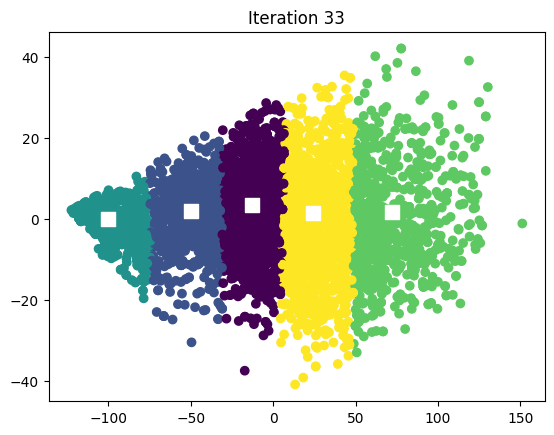

In [ ]:
#write Kmeanalgorithm
# write the body of Kmean algorithm
max_iterations=100  #number of times the algorithm will iterate unless the cluster stop first
k=5
centroids=random_centroids(df, k)
old_centroids=pd.DataFrame()
iteration=1
while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    labels = get_labels(df, centroids)
    centroids = new_centroids(df, labels, k)
    plot_clusters(df, labels, centroids, iteration)
    iteration += 1